In [2]:
# Pre-processing
from google.colab import drive
drive.mount('/content/drive')
%run "/content/drive/MyDrive/ME 470 Work/Computational Model/damper.py"
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

Mounted at /content/drive


In [3]:
def obj_fun(x : tuple, *args):
  mu, E = x
  u, n, exp_num, d, rho, D = args

  test_damper = damper(d, D, mu, E, rho, n, exp = exp_num)

  # have to match sim to test so that least_squares has 1:1 data matchup
  test_damper.match_test(u)

  return test_damper.least_squares()

def optimize(*args): # u in mm/s
  import numpy as np
  from scipy.optimize import minimize
  x0 = (700, 100) # realistic starting point
  res = minimize(obj_fun, x0, method='nelder-mead', \
                args = (args), options={'disp': False})
  return res.x

/content/drive/MyDrive/ME 470 Work/Computational Model/damper.py:60: RuntimeWarning: invalid value encountered in double_scalars
  A_Cd = (19000*self.beta/self.ReD)**0.8
/content/drive/MyDrive/ME 470 Work/Computational Model/damper.py:67: RuntimeWarning: invalid value encountered in double_scalars
  + 0.000521*(10**6*self.beta/self.ReD)**0.7 \
/content/drive/MyDrive/ME 470 Work/Computational Model/damper.py:68: RuntimeWarning: invalid value encountered in double_scalars
  + (0.0188 + 0.0063*A_Cd)*self.beta**(3.5)*(10**6/self.ReD)**0.3 \


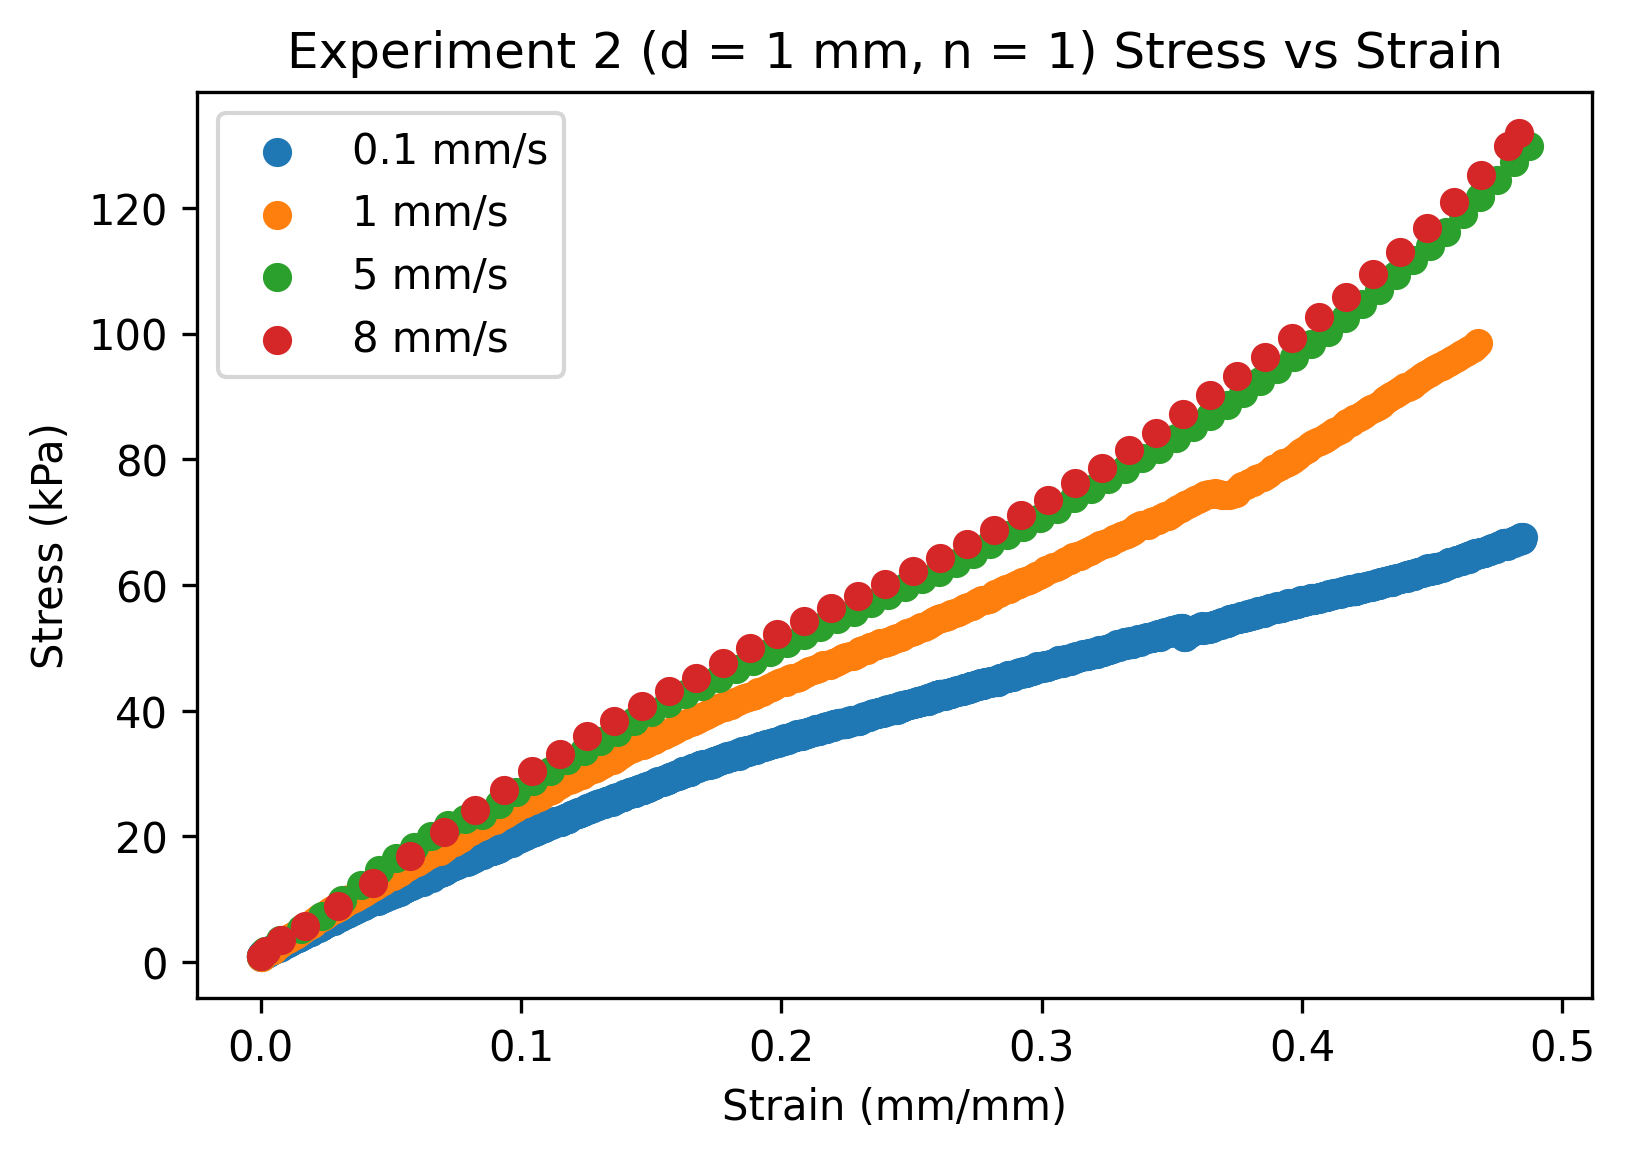

In [4]:
# Experiment 2
import numpy as np

test_speeds = [0.1, 1, 5, 8] # mm/s

vals = np.zeros((len(test_speeds), 2)) # to contain mu and E values from optimization, not experimentally determined

for i in range(len(test_speeds)):
  n = 1
  exp_num = 2
  d = 1E-3 # m
  rho = 1300 # kg/m^3 (toothpaste)
  D = (20 + 23.5)/2 * 1E-3 # m
  u = test_speeds[i] # mm/s
  vals[i,:] = optimize(u, n, exp_num, d, rho, D)

d = 1E-3 # m
D = (20 + 23.5)/2 * 1E-3 # m
rho = 1300 # kg/m^3 (toothpaste)
n = 1

dampers = []

td = []

for i in range(len(test_speeds)):
  mu, E = vals[i, 0], vals[i, 1]
  dampers.append(damper(d, D, mu, E, rho, n, exp = 2))
  u = test_speeds[i] # m/s
  dampers[i].match_test(u)
  plt.scatter(dampers[i].test_strain, dampers[i].test_stress, label = "{} mm/s".format(u))
  td.append(np.array((test_speeds[i]*np.ones((dampers[i].test_strain.size)), dampers[i].test_strain, dampers[i].test_stress)))
plt.title("Experiment 2 (d = 1 mm, n = 1) Stress vs Strain")
plt.xlabel("Strain (mm/mm)")
plt.ylabel("Stress (kPa)")
plt.legend()
plt.show()

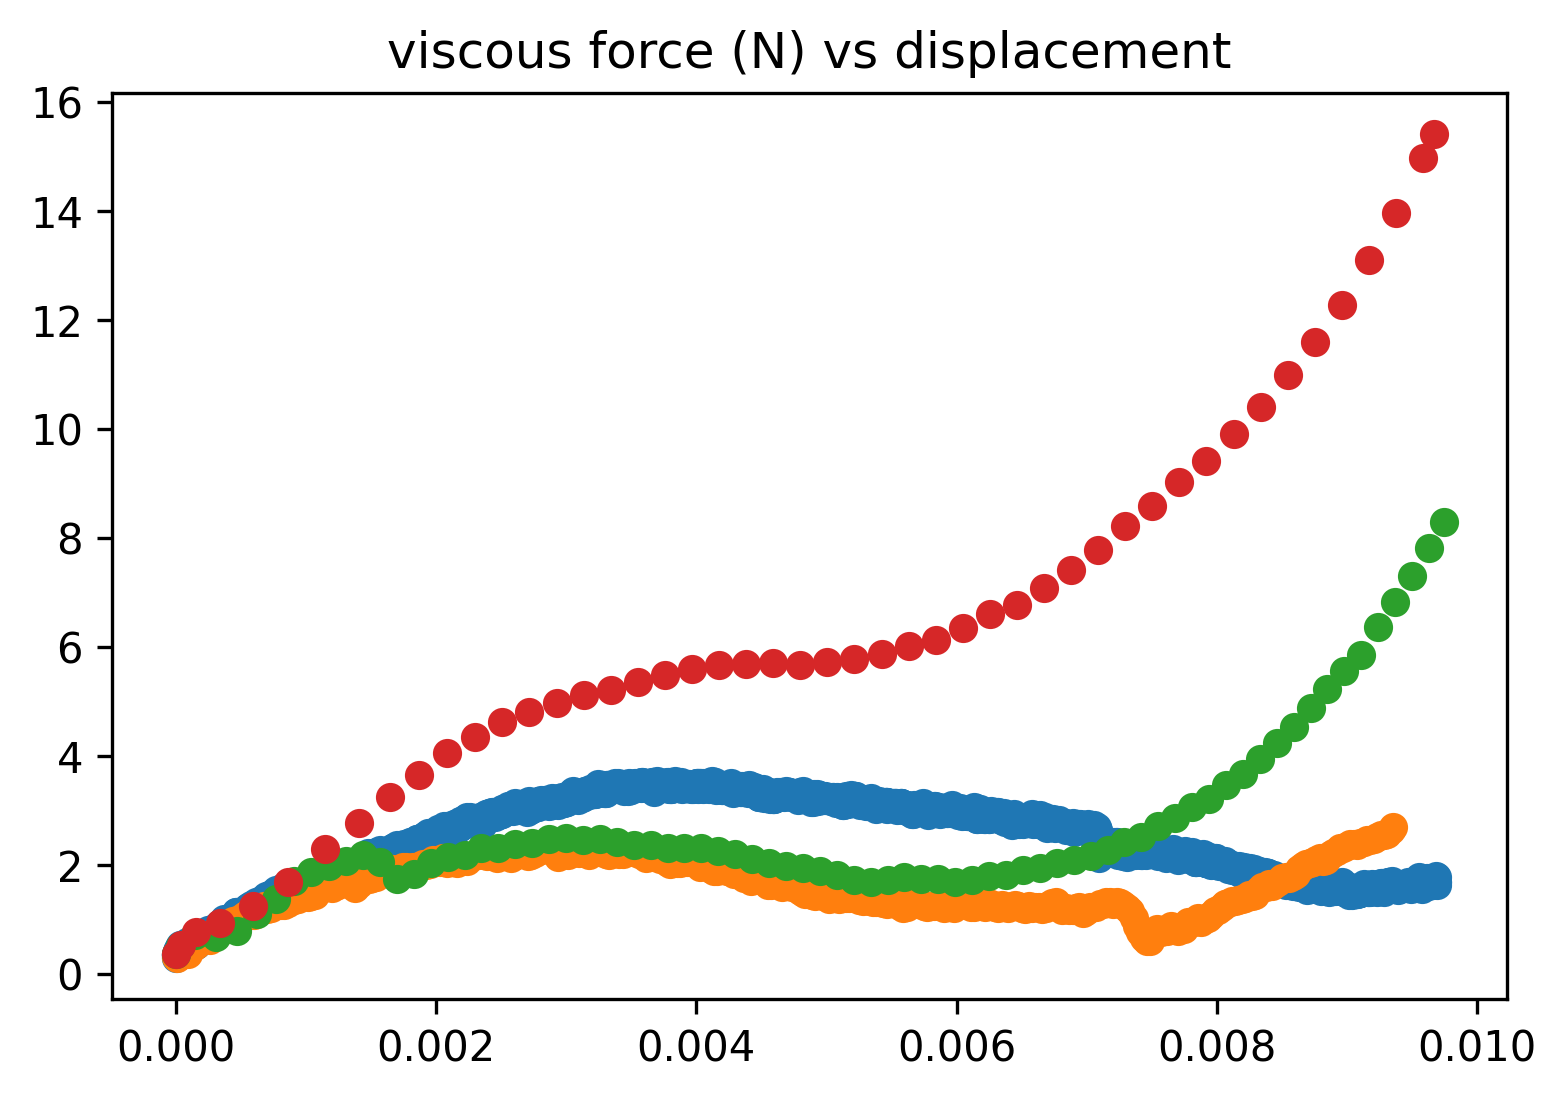

In [5]:
# Exp 2 viscosity determination
test_mus = []
for i in range(len(test_speeds)):
  total_force = np.array(dampers[i].test_force)
  spring_force = np.array(dampers[i].test_disp)*dampers[i].k
  disp = np.array(dampers[i].test_disp)
  plt.scatter(disp, total_force - spring_force)
  viscous_force = (np.average(total_force - spring_force)) # N
  mu = viscous_force*np.pi*(dampers[i].d/2)**4/(8*dampers[i].t*dampers[i].Q*dampers[i].a) # kg/(m-s)
  test_mus.append(mu)
plt.title('viscous force (N) vs displacement')
plt.show()

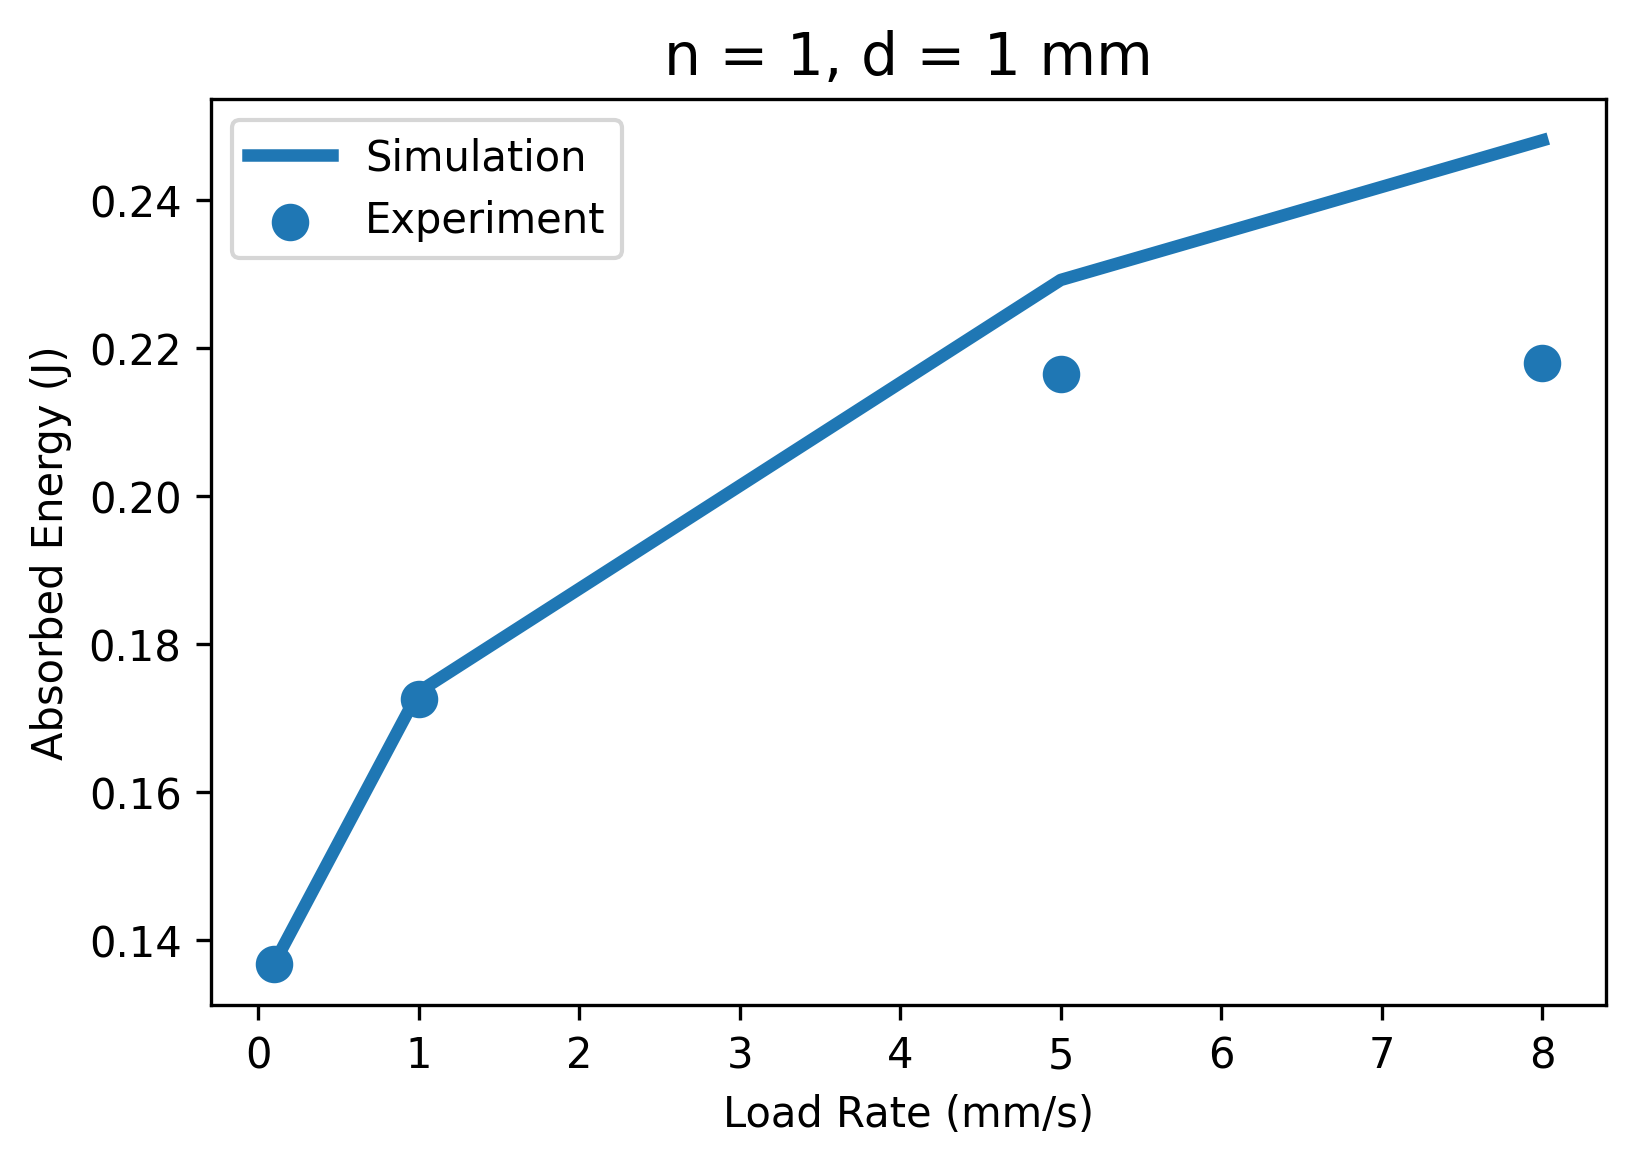

In [6]:
%run "/content/drive/MyDrive/ME 470 Work/Computational Model/damper.py"

# compare simulated and experimental energy

sim_energies = []
exp_energies = []
for damper in dampers:
  sim_energies.append(damper.energy)
  exp_energies.append(damper.left_point_integrate(\
                      damper.test_disp, damper.test_force))

plt.plot(test_speeds, sim_energies, linewidth = 3, label = "Simulation")
plt.scatter(test_speeds, exp_energies, linewidth = 3, label = "Experiment")
plt.title("n = 1, d = 1 mm", fontsize = 14)
plt.xlabel("Load Rate (mm/s)")
plt.ylabel("Absorbed Energy (J)")
plt.legend()
plt.show()

sim_energies2 = sim_energies
exp_energies2 = exp_energies

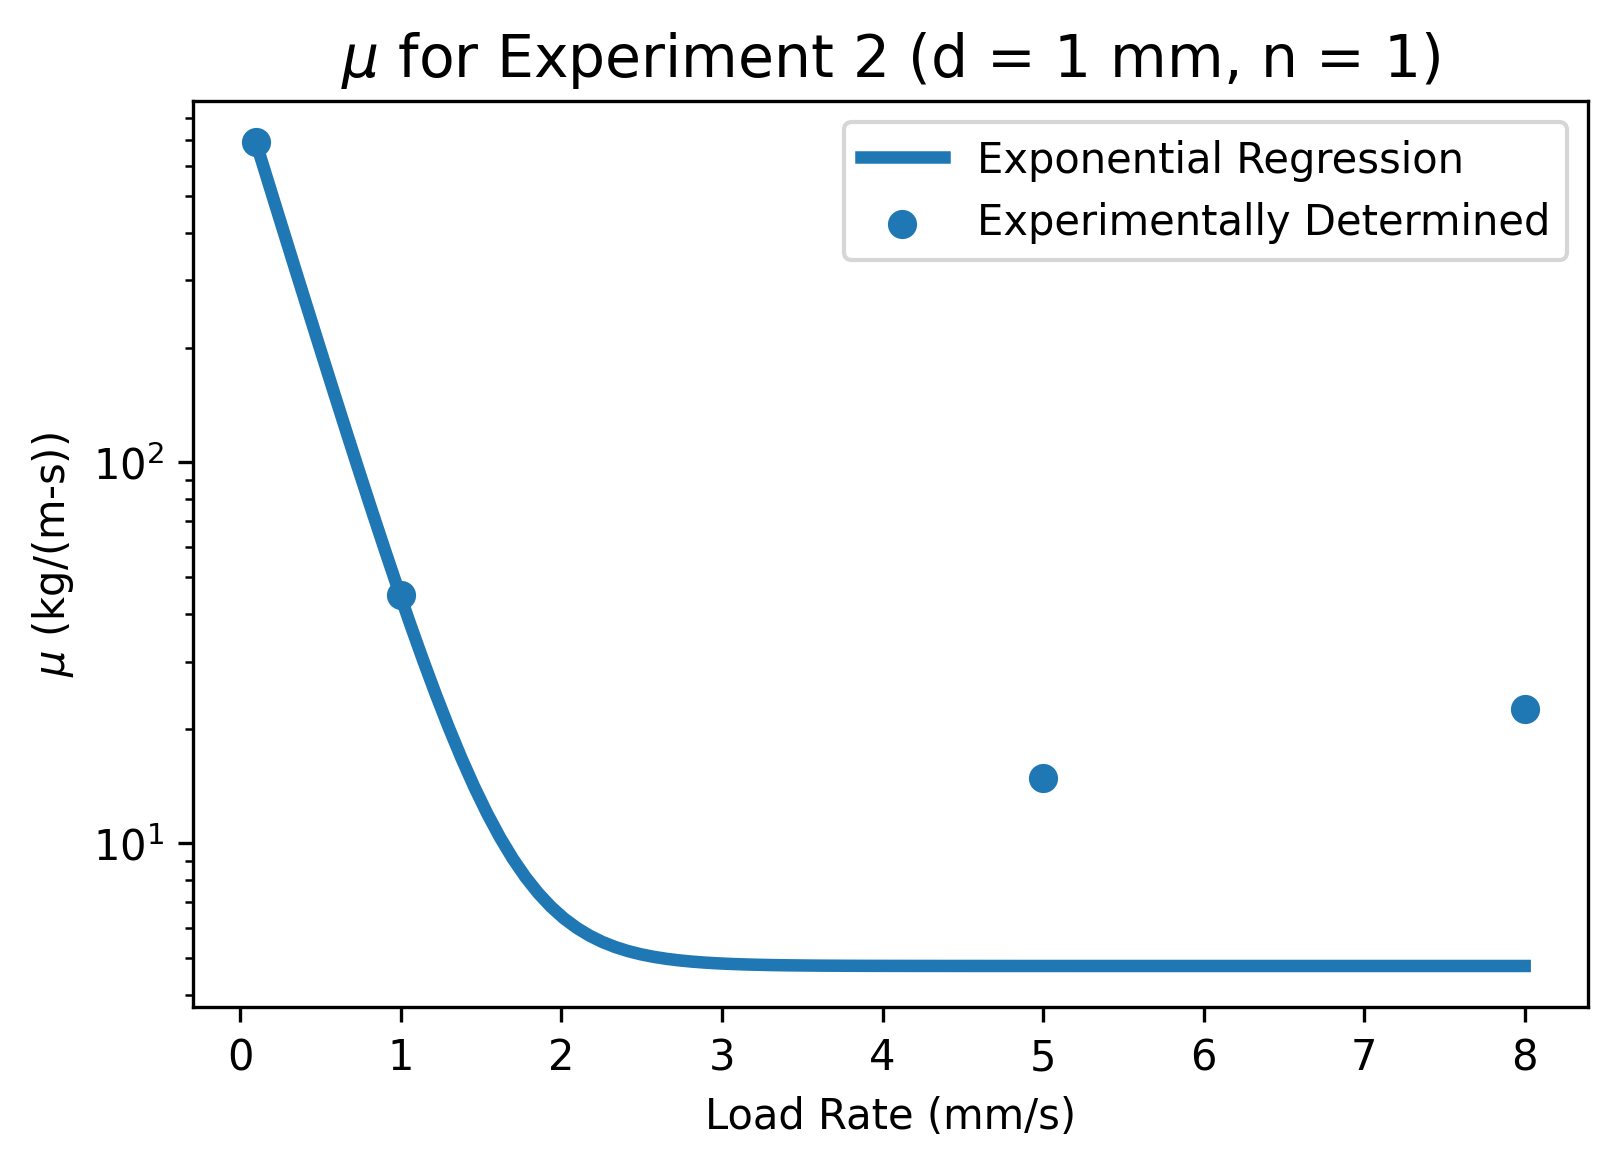

r-squared for mu: 0.998570726988955
mu at 8 m/s: 4.76585402017376 kg/(m-s)


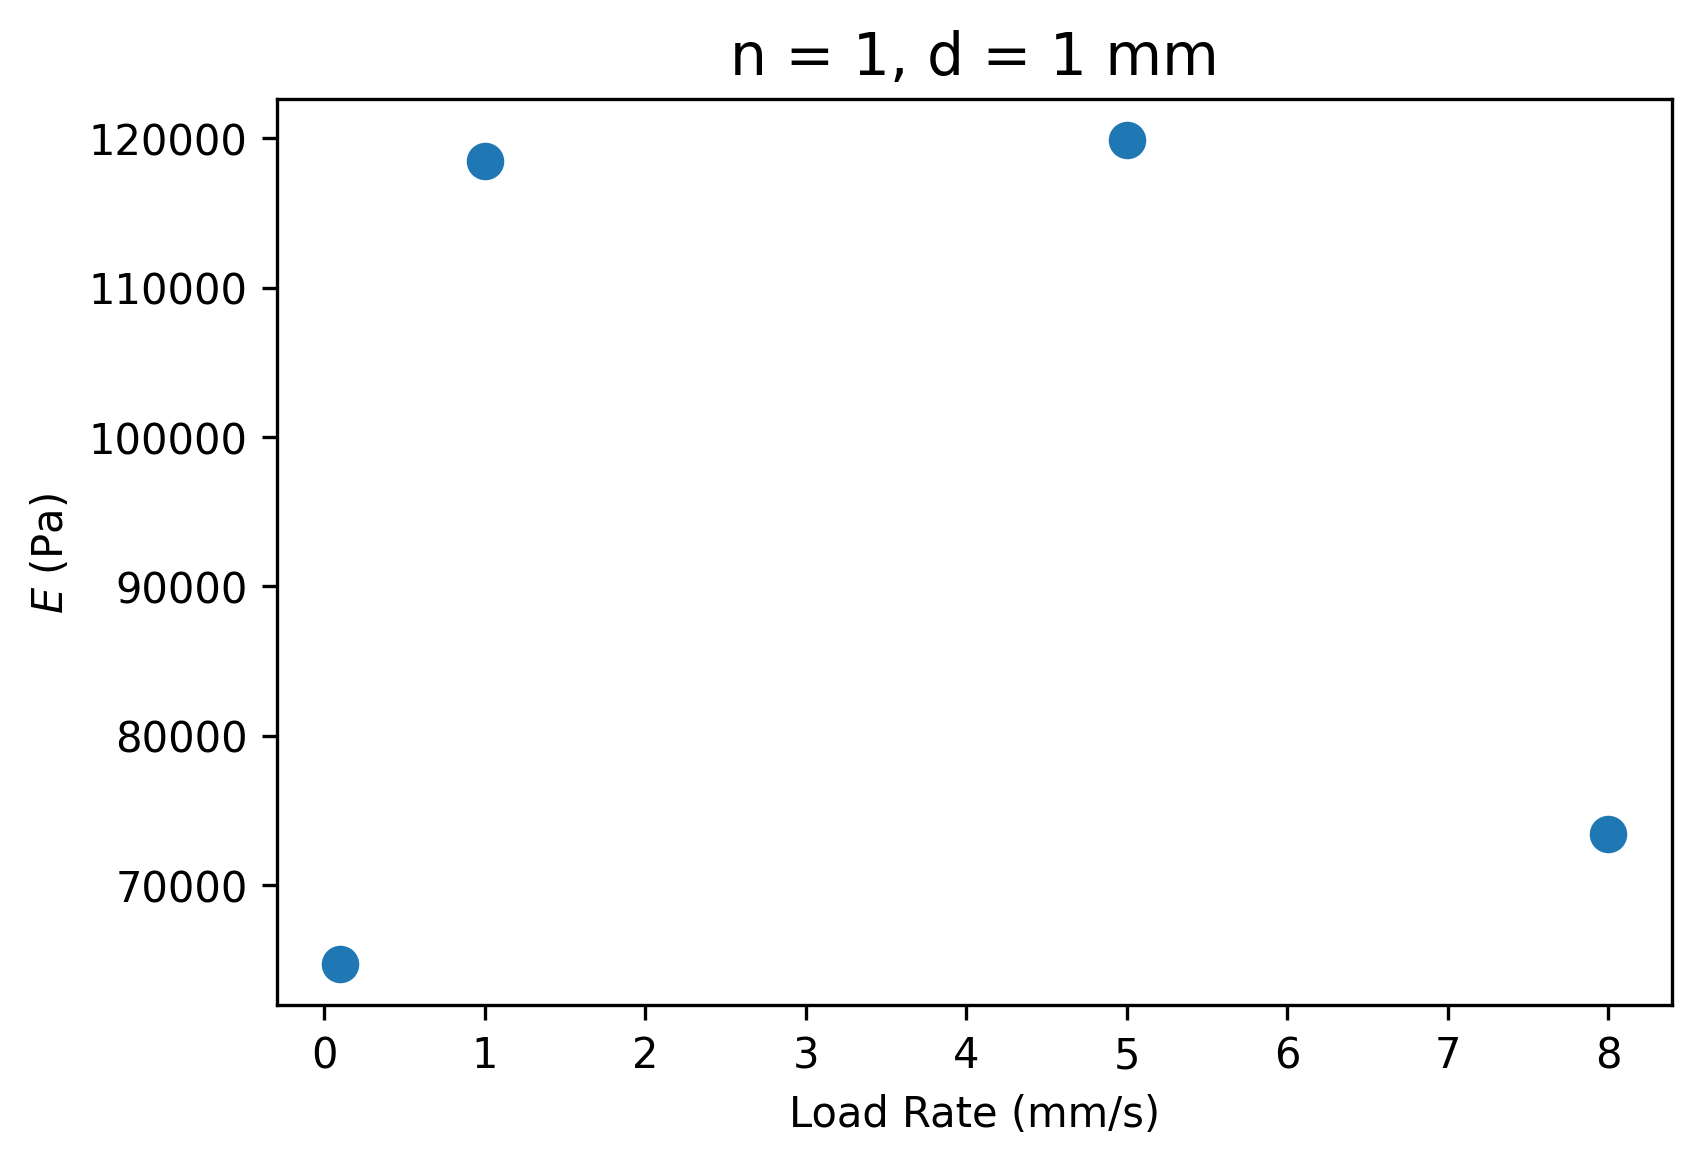

In [7]:
''' Fitting tuned parameters with regression and plotting experimentally determined mu'''

from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

# plot mu (experimental) vs speed
plt.yscale("log")
plt.scatter(test_speeds, test_mus, label = 'Experimentally Determined')
plt.title("$\mu$ for Experiment 2 (d = 1 mm, n = 1)", fontsize = 14)
plt.xlabel("Load Rate (mm/s)")
plt.ylabel("$\mu$ (kg/(m-s))")

# exp decay fit to mu
def func(x, a, b, c):
    return a*np.exp(-b*x)+c 

params, _ = curve_fit(func, test_speeds, vals[:,0])
a, b, c = params[0], params[1], params[2]
x_sample = np.linspace(0.1, 8, 100)
yfit = lambda x: a*np.exp(-x*b)+c
plt.plot(x_sample, yfit(x_sample), linewidth = 3, label = 'Exponential Regression')
plt.legend()
plt.show()
print('r-squared for mu: {}'.format(r2_score(test_mus, a*np.exp(np.array(test_speeds)*-b)+c)))
print('mu at 8 m/s: {} kg/(m-s)'.format(yfit(8000)))
mu_8000 = yfit(8000)

# plot E vs speed
plt.scatter(test_speeds, vals[:,1], linewidth = 3)
plt.title("n = 1, d = 1 mm", fontsize = 14)
plt.xlabel("Load Rate (mm/s)")
plt.ylabel("$E$ (Pa)")
plt.show()

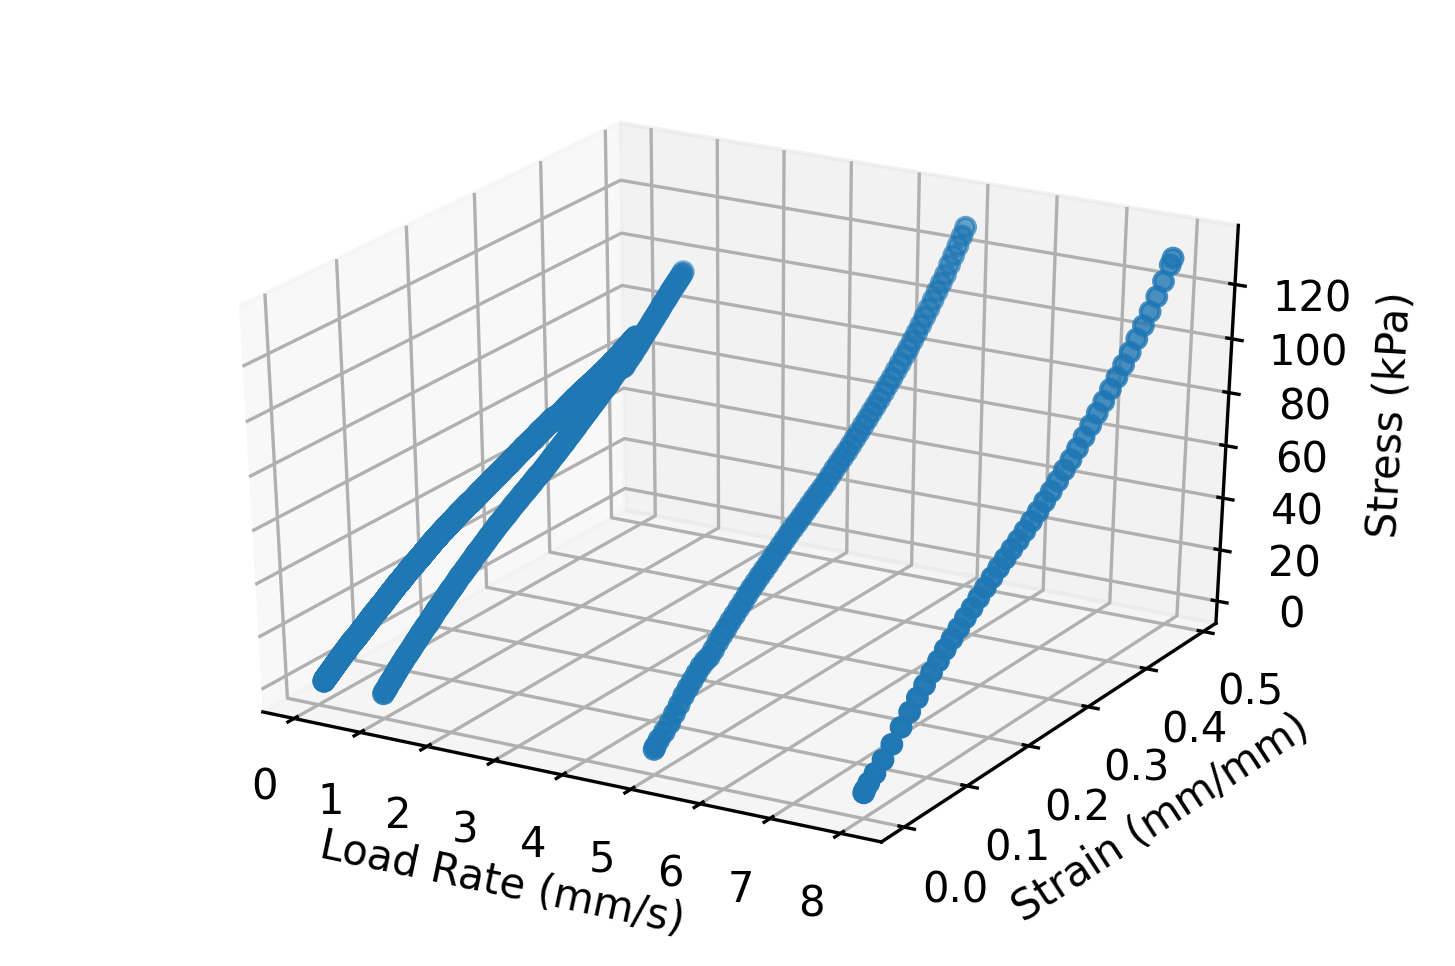

In [8]:
# extra plotting for exp 2 for poster
x = []
for i in range(4):
  for j in td[i][0,:]:
    x.append(j)

y = []
for i in range(4):
  for j in td[i][1,:]:
    y.append(j)

z = []
for i in range(4):
  for j in td[i][2,:]:
    z.append(j)

from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(x, y, z, 'gray')

ax.set_xlabel('Load Rate (mm/s)')
ax.set_ylabel('Strain (mm/mm)')
ax.set_zlabel('Stress (kPa)')

ax.dist = 11